In [1]:
import pandas as pd
df=pd.read_csv('job.csv',encoding='latin-1')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


In [3]:
df.duplicated().sum()

202

In [4]:
df.isnull().sum()

Company                         1
Job Title                       1
Location                        1
Job Type                        1
Experience level              236
Salary                        189
Requirment of the company       0
Facilities                      0
dtype: int64

In [5]:
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


In [6]:
df=df.drop_duplicates()

In [7]:
df['Salary'] = df['Salary'].str.replace('K', '000')
df['Salary'] = df['Salary'].str.replace(r'\D', '', regex=True)

In [8]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

In [9]:
# Define a function to clean individual facilities by removing unwanted entries
def clean_facility(facility):
    return facility.replace(',,,,,', '').replace(',,,,', '').replace(',,,', '').replace(',,', ',')

# Clean the 'Facilities' column
df['Facilities'] = df['Facilities'].apply(clean_facility)


In [10]:
def clean_facilities(row):
    facilities = row['Facilities']
    if not any(c.isalpha() for c in facilities):  # Check if 'Facilities' has no alphabetic characters
        facilities = f"{row['Company']} - {row['Location']} - {row['Job Title']}"
    return facilities

# Apply the custom function to clean and replace the 'Facilities' column
df['Facilities'] = df.apply(clean_facilities, axis=1)

In [12]:
df[df['Job Type'] == 'Internship']['Salary'].isnull().all()

True

In [13]:
df.loc[df['Job Type'] == 'Internship', 'Salary'] = 0

In [14]:
df.dropna(subset=['Experience level', 'Salary'], how='all',inplace=True)

In [15]:
df['Experience level'].unique()

array(['Entry-level', nan, 'Mid-level', 'Senior-level', 'Executive-level'],
      dtype=object)

In [16]:
df['Experience level'].fillna('Unspecified', inplace=True)

In [17]:
median_salary_by_experience_level = df.groupby('Experience level')['Salary'].median()
df['Salary'].fillna(df['Experience level'].map(median_salary_by_experience_level), inplace=True)


In [18]:
from geotext import GeoText
def extract_city_country(location):
    places = GeoText(location)
    cities = list(places.cities)
    countries = list(places.countries)
    city = cities[0] if cities else None
    country = countries[0] if countries else None
    return city, country
df['City'], df['Country'] = zip(*df['Location'].apply(extract_city_country))


In [19]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def get_country_from_city(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.address.split(",")[-1].strip()
    except:
        pass
    return None
df['Country'] = df.apply(lambda row: get_country_from_city(row['City']) if pd.isnull(row['Country']) and pd.notnull(row['City']) else row['Country'], axis=1)

In [20]:
from langdetect import detect
from mtranslate import translate

# Assuming your DataFrame is named 'df'

# Function to translate country name to English
def translate_to_english(country_name):
    try:
        # Detect the language of the country name
        lang = detect(country_name)
        
        # If the language is not English, translate to English
        if lang != 'en':
            translated_name = translate(country_name, 'en', lang)
            return translated_name
        else:
            return country_name
    except:
        return country_name

# Update the 'Country' column with translated English country names
df['Country'] = df['Country'].apply(translate_to_english)


In [22]:
# import pycountry
# short_to_full_country_mapping = {country.alpha_2: country.name for country in pycountry.countries}
# def extract_country(location, country):
#     if pd.isnull(country): 
#         if "remote" in location.lower():
#             return "Remote"
#         for i in range(len(location) - 1):
#             if location[i].isupper() and location[i + 1].isupper():
#                 country_code = location[i:i+2]
#                 # Check if country code is a short name and replace with full name
#                 country = short_to_full_country_mapping.get(country_code, country)
#                 return country
#     return country
# df['Country'] = df.apply(lambda row: extract_country(row['Location'], row['Country']), axis=1)

In [26]:
df['Country'] = df['Country'].fillna('Unknown')

In [24]:
len(df[df['Country']=='Unknown'])

0

In [27]:
df.isnull().sum()

Company                         0
Job Title                       0
Location                        0
Job Type                        0
Experience level                0
Salary                          0
Requirment of the company       0
Facilities                      0
City                          817
Country                         0
dtype: int64

In [ ]:
# import pandas as pd
# import re
# from collections import Counter


# # Join all the job titles into a single string
# all_job_titles = ' '.join(df['Job Title'])

# # Tokenize the text into words (using regex to handle word boundaries)
# tokens = re.findall(r'\b\w+\b', all_job_titles)

# # Count the occurrences of each word
# word_counts = Counter(tokens)

# # Get the most common words and their frequencies
# most_common_words = word_counts.most_common()

# # Display the most common words and their frequencies
# print(most_common_words)


[('Data', 2028), ('Engineer', 1106), ('Senior', 713), ('Analyst', 608), ('Scientist', 479), ('Learning', 342), ('Machine', 327), ('Manager', 221), ('Analytics', 194), ('Business', 181), ('Intelligence', 170), ('AI', 155), ('Lead', 139), ('Software', 139), ('Science', 138), ('Staff', 130), ('Product', 112), ('and', 108), ('Research', 105), ('Developer', 102), ('Engineering', 98), ('Sr', 91), ('m', 91), ('Remote', 89), ('BI', 82), ('Architect', 80), ('f', 77), ('ML', 75), ('Consultant', 71), ('Management', 69), ('Intern', 69), ('Specialist', 67), ('F', 66), ('Director', 64), ('H', 54), ('Operations', 53), ('d', 52), ('Principal', 50), ('Platform', 49), ('of', 49), ('Applied', 46), ('Junior', 42), ('Robotics', 42), ('Cloud', 41), ('Marketing', 40), ('Big', 40), ('Associate', 39), ('Team', 39), ('Infrastructure', 38), ('II', 37), ('for', 33), ('Computer', 32), ('Vision', 30), ('Power', 29), ('x', 27), ('Quality', 26), ('Customer', 26), ('Head', 26), ('Technical', 25), ('Python', 25), ('I',

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans

# # Step 2: Feature Extraction using TF-IDF
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df['Job Title'])

# # Step 3: K-Means Clustering
# num_clusters = 3  # Number of job domains to cluster
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(X)

# # Step 4: Extracting Job Domains
# labels = kmeans.labels_

# # Job domains mapping
# domain_mapping = {
#     'Big': 'Big Data',
#     'Data Analyst': 'Data Analyst',
#     'Analytics': 'Data Analyst',
#     'Analyst': 'Data Analyst',
#     'Scientist': 'Data Scientist',
#     'Machine Learning': 'Machine Learning',
#     'ML': 'Machine Learning',
#     'Machine learning': 'Machine Learning',
#     'Business': 'Business Intelligence',
#     'BI': 'Business Intelligence',
#     'Data Management': 'Data Management',
#     'Data Architect': 'Data Architect',
#     'Engineer Data': 'Engineer Data',
#     'data': 'Data Scientist',
#     'AI': 'Artificial intelligence',
#     'Artificial': 'Artificial intelligence',
#     'Software': 'Software Engineer',
#     'Computer': 'Computer Engineer',
#     'Software Engineer': 'Software Engineer',
#     'Web Developer': 'Web Developer',
#     'Database Administrator': 'Database Administrator',
#     'IT Support Specialist': 'IT Support Specialist',
#     'Développeur': 'IT Developer',
#     'Robotics': 'Robotics Engineer',
#     'Research Engineer': 'Research Engineer',
#     'Deep Learning Engineer': 'Deep Learning Engineer',
#     'Engineering Manager': 'Engineering Manager',
#     'Product Manager': 'Product Manager',
#     'Research Analyst': 'Research Analyst',
#     'ETL': 'ETL Developer',
#     'DevOps': 'DevOps Engineer',
#     'Deep Learning': 'Deep Learning',
#     'Frontend': 'Frontend Developer',
#     'Developer': 'IT Developer',
#     'Development': 'IT Developer',
# }

# # Function to assign the job domain name based on keyword matching
# def assign_job_domain(row):
#     for keyword, domain in domain_mapping.items():
#         if row['Job Title'].lower().find(keyword.lower()) != -1:
#             return domain
#     return 'IT Developer'

# # Step 5: Assigning Job Domains to Job Titles
# df['Job Domain'] = df.apply(assign_job_domain, axis=1)


In [ ]:
domain_mapping = {
    'Big': 'Big Data',
    'Data Analyst': 'Data Analyst',
    'Analytics': 'Data Analyst',
    'Analyst': 'Data Analyst',
    'Scientist': 'Data Scientist',
    'Machine Learning': 'Machine Learning',
    'ML': 'Machine Learning',
    'Machine learning': 'Machine Learning',
    'Business': 'Business Intelligence',
    'BI': 'Business Intelligence',
    'Data Management': 'Data Management',
    'Data Architect': 'Data Architect',
    'Engineer Data': 'Engineer Data',
    'data': 'Data Scientist',
    'AI': 'Artificial intelligence',
    'Artificial': 'Artificial intelligence',
    'Software': 'Software Engineer',
    'Computer': 'Computer Engineer',
    'Software Engineer': 'Software Engineer',
    'Web Developer': 'Web Developer',
    'Database Administrator': 'Database Administrator',
    'IT Support Specialist': 'IT Support Specialist',
    'Développeur': 'IT Developer',
    'Robotics': 'Robotics Engineer',
    'Research Engineer': 'Research Engineer',
    'Deep Learning Engineer': 'Deep Learning Engineer',
    'Engineering Manager': 'Engineering Manager',
    'Product Manager': 'Product Manager',
    'Research Analyst': 'Research Analyst',
    'ETL': 'ETL Developer',
    'DevOps': 'DevOps Engineer',
    'Deep Learning': 'Deep Learning',
    'Frontend': 'Frontend Developer',
    'Developer': 'IT Developer',
    'Development': 'IT Developer',
}
# Function to assign the job domain name based on keyword matching
def assign_job_domain(job_title):
    for keyword, domain in domain_mapping.items():
        if keyword.lower() in job_title.lower():
            return domain
    return 'IT Developer'


# Step 5: Assigning Job Domains to Job Titles
df['Job Domain'] = df['Job Title'].apply(assign_job_domain)



In [29]:
df[['Job Title', 'Job Domain']].sample(n=5)

,Job Title,Job Domain
257,Senior Data Scientist,Data Scientist
384,Sr. Manager (AI/ML),Machine Learning
2141,Data Engineer,Data Scientist
2323,Full stack Data Scientist,Data Scientist
1542,Data Engineer (MIDI and Audio),Data Scientist


In [30]:
import plotly.express as px

# Count the occurrences of each domain in the 'Job Domain' column
job_domain_counts = df['Job Domain'].value_counts()

# Create the bar chart using Plotly Express
fig = px.bar(
    job_domain_counts,
    x=job_domain_counts.index,
    y=job_domain_counts.values,
    color=job_domain_counts.index,
    labels={'x': 'Job Domain', 'y': 'Number of Job Listings'},
    title='Trends Job Domain'
)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
# Calculate the average salary for each job domain
df_avg_salary = df.groupby('Job Domain')['Salary'].mean().reset_index()

df_top_10 = df_avg_salary.nlargest(10, 'Salary')

# Create a bar plot using Plotly
fig = px.bar(df_top_10, x='Job Domain', y='Salary', color='Salary',
             labels={'Salary': 'Average Salary (USD)'}, title='Top 10 Job Domains by Average Salary')

# Customize the plot
fig.update_layout(
    xaxis_title=None,
    yaxis_title='Average Salary (USD)',
    coloraxis_showscale=False,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white'
)
fig.show()


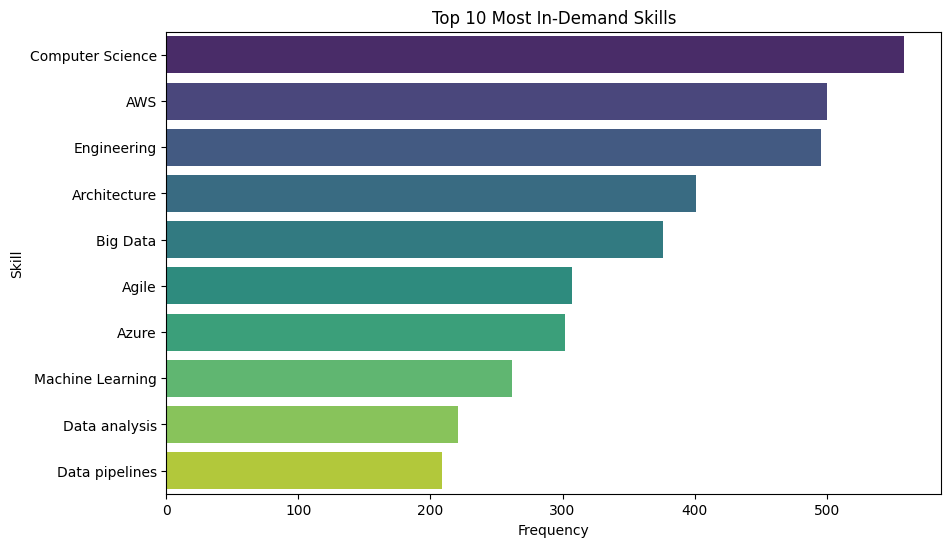

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']
filtered_df = df[df['Job Domain'].isin(domains)]

filtered_df = filtered_df.dropna(subset=['Requirment of the company '])
filtered_df = filtered_df[filtered_df['Requirment of the company '] != '']

skills_count = filtered_df['Requirment of the company '].str.split(',').explode().str.strip().value_counts()

# Remove any empty skill values from the skills_count DataFrame
skills_count = skills_count[skills_count.index != '']

top_skills = 10
top_skills_df = skills_count.nlargest(top_skills)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_skills_df.values, y=top_skills_df.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Skill')
plt.title('Top 10 Most In-Demand Skills')
plt.show()


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the domains of interest
# domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']

# # Filter the data to include only the specified domains
# filtered_df = df[df['Job Domain'].isin(domains)]

# # Drop rows with null or empty values in 'Requirment of the company' column
# filtered_df = filtered_df.dropna(subset=['Requirment of the company '])
# filtered_df = filtered_df[filtered_df['Requirment of the company '] != '']

# # Create separate DataFrames for each domain
# domain_dfs = {}
# for domain in domains:
#     domain_dfs[domain] = filtered_df[filtered_df['Job Domain'] == domain]

# # Find the top 5 skills requirement for each domain
# top_skills_by_domain = {}
# for domain, domain_df in domain_dfs.items():
#     skills_count = domain_df['Requirment of the company '].str.split(',').explode().str.strip().value_counts()
#     # Remove any empty skill values
#     skills_count = skills_count[skills_count.index != '']
#     top_skills_by_domain[domain] = skills_count.nlargest(5)

# # Create horizontal bar charts for each domain using Seaborn
# plt.figure(figsize=(12, 8))
# for i, (domain, top_skills_df) in enumerate(top_skills_by_domain.items(), 1):
#     plt.subplot(1, 3, i)
#     sns.barplot(x=top_skills_df.values, y=top_skills_df.index, palette='viridis')
#     plt.xlabel('Frequency')
#     plt.ylabel('Skill')
#     plt.title(f'Top 5 Skills Requirement in {domain}')

# plt.tight_layout()
# plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Filter the data for AI, DS, and Big Data domains
domains = ['Artificial intelligence', 'Data Scientist', 'Big Data']
filtered_df = df[df['Job Domain'].isin(domains)]

# Remove rows with null or empty values in 'Requirment of the company' column
filtered_df = filtered_df.dropna(subset=['Requirment of the company '])
filtered_df = filtered_df[filtered_df['Requirment of the company '] != '']

# Locations comparison using Plotly Express choropleth map
fig = px.choropleth(filtered_df, 
                    locations='Country', 
                    locationmode='country names',
                    color='Job Domain',
                    title='Comparison of Job Locations in AI, DS, and Big Data',
                    labels={'Country': 'Country', 'Job Domain': 'Job Domain'},
                    scope='world',  # Set the scope to 'world' for a global map
                    color_discrete_map={
                        'Artificial intelligence': 'blue',
                        'Data Scientist': 'green',
                        'Big Data': 'orange'
                    }
                   )
fig.update_layout(autosize=True, margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Group data by 'Country' and count the occurrences of each job domain
domain_counts_by_country = df.groupby(['Country', 'Job Domain']).size().reset_index(name='Count')

# Find the most common job domain in each country
most_common_domain_by_country = domain_counts_by_country.groupby('Country', as_index=False)['Job Domain'].agg(lambda x: x.value_counts().idxmax())

# Create a choropleth map to show the most common job domain in each country
fig = px.choropleth(
    most_common_domain_by_country,
    locations='Country',
    locationmode='country names',
    color='Job Domain',
    labels={'Country': 'Country', 'Job Domain': 'Job Domain'},
    scope='world',
    color_discrete_sequence=px.colors.qualitative.Dark24,
    title='Most Common Job Domain in Each Country'
)
fig.update_layout(autosize=True, margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
fig.show()


In [ ]:
# import pandas as pd
# import pyodbc

# # Assuming you have loaded the data into the DataFrame 'df'

# # Connect to the SQL Server database
# connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-5VUQJT8J\SQLEXPRESS;DATABASE=Job;Trusted_Connection=yes;'
# conn = pyodbc.connect(connection_string)

# # Create a cursor
# cursor = conn.cursor()

# # Insert data into the Country table
# countries = df[['Country']].drop_duplicates()
# for _, country in countries.iterrows():
#     cursor.execute(f"INSERT INTO Country (CountryName) VALUES ('{country['Country']}')")

# # Insert data into the DomainJob table
# domains = df[['Job Domain']].drop_duplicates()
# for _, domain in domains.iterrows():
#     cursor.execute(f"INSERT INTO DomainJob (DomainName) VALUES ('{domain['Job Domain']}')")

# # Insert data into the ExperienceLevel table
# levels = df[['Experience level']].drop_duplicates()
# for _, level in levels.iterrows():
#     cursor.execute(f"INSERT INTO ExperienceLevel (LevelName) VALUES ('{level['Experience level']}')")

# # Insert data into the JobType table
# job_types = df[['Job Type']].drop_duplicates()
# for _, job_type in job_types.iterrows():
#     cursor.execute(f"INSERT INTO JobType (TypeName) VALUES ('{job_type['Job Type']}')")

# # Commit the changes and close the connection
# conn.commit()
# conn.close()


In [ ]:
# import pandas as pd
# import pyodbc

# # Assuming you have loaded the data into the DataFrame 'df'

# # Connect to the SQL Server database
# connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-5VUQJT8J\SQLEXPRESS;DATABASE=Job;Trusted_Connection=yes;'

# try:
#     # Establish the connection
#     conn = pyodbc.connect(connection_string)

#     # Create a cursor
#     cursor = conn.cursor()

#     # Now, insert data into the 'Offer_Job' table
#     for _, row in df.iterrows():
#         # Retrieve foreign key values using subqueries with TOP 1
#         country_id_query = f"(SELECT TOP 1 Id FROM Country WHERE CountryName = ?)"
#         domain_id_query = f"(SELECT TOP 1 Id FROM DomainJob WHERE DomainName = ?)"
#         level_id_query = f"(SELECT TOP 1 Id FROM ExperienceLevel WHERE LevelName = ?)"
#         type_id_query = f"(SELECT TOP 1 Id FROM JobType WHERE TypeName = ?)"

#         cursor.execute(f"""
#             INSERT INTO [dbo].[Offer_Job]
#                    ([CompanyName]
#                    ,[JobTitle]
#                    ,[Location]
#                    ,[Salary]
#                    ,[RequirmentOfTheCompany]
#                    ,[Facilities]
#                    ,[CountryId]
#                    ,[JobDomainId]
#                    ,[ExperienceLevelId]
#                    ,[JobTypeId])
#              VALUES
#                    (?, ?, ?, ?, ?, ?, ({country_id_query}), ({domain_id_query}),
#                    ({level_id_query}), ({type_id_query}))
#         """, row['Company'], row['Job Title'], row['Location'], row['Salary'],
#            row['RequirmentOfTheCompany'], row['Facilities'], row['Country'],
#            row['Job Domain'], row['Experience level'], row['Job Type'])

#     # Commit the changes
#     conn.commit()

# except Exception as e:
#     # Handle exceptions here
#     print("An error occurred:", e)

# finally:
#     # Close the connection
#     conn.close()
